In [1]:
#=pkgs = [
	"CategoricalArrays","Chain","Conda","CSV","DataFrames","Dates",
	"FileIO","HTTP","ImageShow","LaTeXStrings","Metrics","Plots",
	"Plotly","PrettyTables","PyCall","Statistics","StatsBase",
	"StatsPlots","StateSpaceModels","XLSX"
	];
expr = "using " * join(pkgs, ", ")
eval(Meta.parse(expr))=#

In [2]:
#=using PlutoUI; PlutoUI.TableOfContents(
    title = "Pronóstico de Inflación por Componentes", 
    depth = 5)=#
#using CategoricalArrays,Chain,Conda,CSV,DataFrames,Dates,FileIO,HTTP
#using ImageShow,LaTeXStrings,Metrics,Plots,Plotly,PrettyTables,PyCall
#using Statistics,StatsBase,StatsPlots,StateSpaceModels,XLSX;
using CSV,DataFrames,Dates,FileIO,GLM
using Plots,PrettyTables,PyCall,StateSpaceModels
# Pkg.add(PackageSpec(name="PyCall", rev="master"))
# Pkg.build("PyCall")

# within a Julia REPL
# using Conda
# Conda.pip_interop(true)
# Conda.pip("install", "webio_jupyter_extension")

wd = @__DIR__

#get_grouped_indices()
include(wd * "/Functions/update_data.jl");  # Obtener información
include(wd * "/Functions/plot_type.jl");   # Gráficos dinámicos o estáticos
include(wd * "/Functions/apply_models.jl");   # Modelos	

\pagebreak

# Resumen Ejecutivo

En este documento se expone un proceso en Julia para calcular variaciones mensuales e interanuales (y la contribución de los componentes a dichas variaciones) a partir de los componentes del Indice de Precios al Consumidor (IPC). En el mismo se obtiene lo siguiente, por cada agrupación y sus componentes:

- Índice;
- Tasa de crecimiento mensual (pendiente);
- Tasa de crecimiento interanual (pendiente);
- Contribución a la tasa de crecimiento mensual (pendiente); y
- Contribución a la tasa de crecimiento interanual (pendiente).

El procedimiento se realiza mediante funciones programadas, por lo que los cálculos a partir de los grupos se realizan automáticamente, tomando en cuenta el número de grupos que se necesite crear; la automatización implica la eliminación de errores que puedan generarse al usar fórmulas en Excel.

\pagebreak

# Datos Iniciales

## Página Web, grupos


In [3]:
# Conda.pip("install", "openpyxl")
#import Conda
#Conda.add("openpyxl")
#using PyCall
#PyCall.@pyimport openpyxl
pd = PyCall.pyimport("pandas");

In [4]:
# Read Excel data
url = "https://www.bch.hn/estadisticos/GIE/LIBSERIE%20IPC%20RUBROS/Serie%20Mensual%20y%20Promedio%20Anual%20del%20%C3%8Dndice%20de%20Precios%20al%20Consumidor%20por%20Rubros.xlsx"
df_cpi_grupos = pd.read_excel(url)

# Drop columns and rows with missing values
df_cpi_grupos = df_cpi_grupos.dropna(axis=1, thresh=3)
df_cpi_grupos = df_cpi_grupos.dropna(axis=0, thresh=3)
df_cpi_grupos = df_cpi_grupos.dropna(axis=1)

# Drop first row (name of variables in Spanish)
df_cpi_grupos = df_cpi_grupos.drop(df_cpi_grupos.index[0])

# Rename columns
df_cpi_grupos.columns = [
    "Fechas",
    "Alimentos y Bebidas no Alcohólicas",
    "Bebidas Alcohólicas y Tabaco",
    "Prendas de Vestir y Calzado",
    "Alojamiento, Agua, Electricidad, Gas y Otros Combustibles",
    "Muebles y Artículos para la Conservación del Hogar",
    "Salud",
    "Transporte",
    "Comunicaciones",
    "Recreación y Cultura",
    "Educación",
    "Restaurantes y Hoteles",
    "Cuidado Personal",
    "IPC"]

# To DataFrame
df_cpi_grupos = DataFrames.DataFrame([col => Base.collect(df_cpi_grupos[col]) for col in df_cpi_grupos.columns])
df_cpi_grupos = df_cpi_grupos[2:end,:]

# Drop rows containing "PROMEDIO"
df_cpi_grupos = DataFrames.filter(
	row -> row.Fechas != "PROMEDIO", df_cpi_grupos)

# # Add months as date
df_cpi_grupos.Fechas = Base.collect(
	Dates.Date(1991,1,1):Dates.Month(1):Dates.Date(1991,1,1)+Dates.Month(size(df_cpi_grupos)[1]-1))

# Guardar en archivo y leer en formato correcto
CSV.write(
	wd * "/Results/data_rubros_web.csv", 
	delim = ';',
	df_cpi_grupos);
df_cpi_grupos = CSV.read(
	#dir * "./Data/Base/data.csv",
	wd * "/Results/data_rubros_web.csv", 
	DataFrames.DataFrame);

En este informe se presenta el gráfico del primer componente del grupo, sin embargo, puede obtenerse un gráfico por cada componente y del IPC general^[j=13 en el código.].


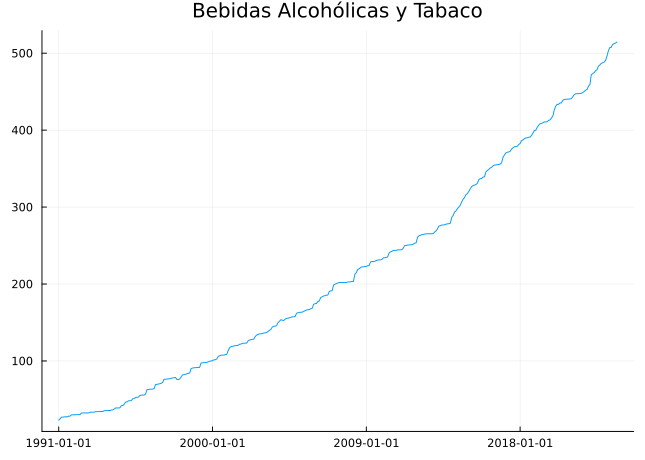

In [5]:
tipo = "line";
grupos2 = DataFrames.DataFrame(
	No = 1:Base.size(df_cpi_grupos, 2)-1,
	Nombre = DataFrames.names(df_cpi_grupos)[2:end]);
nombrar = Base.Array(grupos2.Nombre);
nombrar = string.(nombrar);
j = 2#size(nombrar)[1] # 1:13

#dynamic_plot(df, nombrar[i], tipo)
# static_plot(df_cpi_grupos, nombrar[j], tipo)
df, col_name, plot_type = df_cpi_grupos, nombrar[j], tipo
col_name = Symbol(col_name)
plot_type = Symbol(plot_type)
fig_001 = Plots.plot(
    df.Fechas, 
    df[:, col_name],
    legend = false,
    label = String(col_name),
    title = String(col_name),)
#=Plots.savefig(
	fig_001,
	wd * "/Figuras/fig_001.png")
FileIO.load(wd * "/Figuras/fig_001.png")=#

Los pesos de cada rubro pueden aproximarse mediante una regresión lineal:


In [6]:
data = copy(df_cpi_grupos[:,2:end])
xnames = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","Y"]
DataFrames.rename!(data, Base.names(data) .=> xnames);
reg = GLM.lm(GLM.@formula(Y ~  0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12),data)
w = coef(reg)
data[:,:IPC_estim] = data[:,end]
data[!,:IPC_estim] = 
	data.x1 .* w[1] + data.x2 .* w[2] + data.x3 .* w[3] + 
	data.x4 .* w[4] + data.x5 .* w[5] + data.x6 .* w[6] +
	data.x7 .* w[7] + data.x8 .* w[8] + data.x9 .* w[9] + 
	data.x10 .* w[10] + data.x11 .* w[11] + data.x12 .* w[12]
DataFrames.rename!(
	data, 
	Base.names(data) .=> 
	vcat(Base.names(df_cpi_grupos)[2:end],"IPC_Estim"));
data = hcat(df_cpi_grupos[:,1],data)
DataFrames.rename!(
	data, 
	Base.names(data)[1] .=> 
	"Fechas");
formato_tabla(data[end-20:end,1:6])
formato_tabla(data[end-20:end,7:end])

 ------------ ------------------------------------ ------------------------------ ----------------------------- ----------------------------------------------------------- ----------------------------------------------------
      Fechas   Alimentos y Bebidas no Alcohólicas   Bebidas Alcohólicas y Tabaco   Prendas de Vestir y Calzado   Alojamiento, Agua, Electricidad, Gas y Otros Combustibles   Muebles y Artículos para la Conservación del Hogar 
        Date                              Float64                        Float64                       Float64                                                     Float64                                              Float64 
 ------------ ------------------------------------ ------------------------------ ----------------------------- ----------------------------------------------------------- ----------------------------------------------------
  2022-01-01                             317.5000                       457.2000                    

 ---------- ------------ ---------------- ---------------------- ----------- ------------------------ ------------------ ---------- -----------
     Salud   Transporte   Comunicaciones   Recreación y Cultura   Educación   Restaurantes y Hoteles   Cuidado Personal        IPC   IPC_Estim 
   Float64      Float64          Float64                Float64     Float64                  Float64            Float64    Float64     Float64 
 ---------- ------------ ---------------- ---------------------- ----------- ------------------------ ------------------ ---------- -----------
  473.4000     404.8000          77.3000               269.2000    684.7000                 397.3000           346.8000   373.0000    373.3323
  477.0000     409.2000          77.4000               272.6000    744.2000                 402.2000           348.9000   374.3000    374.3392
  480.7000     413.5000          77.3000               277.6000    744.2000                 404.5000           350.9000   377.8000    378.

## Página Web, Regiones


In [7]:
url = "https://www.bch.hn/estadisticos/GIE/LIBSerie%20IPC%20Region/Serie%20Mensual%20y%20Promedio%20Anual%20del%20%C3%8Dndice%20de%20Precios%20al%20Consumidor%20por%20Regi%C3%B3n.xlsx"

# Read Excel data
df_cpi_regiones = pd.read_excel(url)

# Drop columns and rows with missing values
df_cpi_regiones = df_cpi_regiones.dropna(axis=1, thresh=3)
df_cpi_regiones = df_cpi_regiones.dropna(axis=0, thresh=3)
df_cpi_regiones = df_cpi_regiones.dropna(axis=1)

# Drop first row (name of variables in Spanish)
df_cpi_regiones = df_cpi_regiones.drop(df_cpi_regiones.index[0])

# Rename columns
df_cpi_regiones.columns = [
    "Fechas",
    "Central_Metropolitana",
    "Resto_Central",
    "Norte_Metropolitana",
    "Resto_Norte",
    "Sur",
    "Oriental",
    "Occidental",
    "IPC"];

# To DataFrame
df_cpi_regiones = DataFrames.DataFrame([col => Base.collect(df_cpi_regiones[col]) for col in df_cpi_regiones.columns])
df_cpi_regiones = df_cpi_regiones[2:end,:]

# # Drop rows containing "PROMEDIO"
df_cpi_regiones = DataFrames.filter(
	row -> row.Fechas != "Promedio", df_cpi_regiones)

# Add months as date
df_cpi_regiones.Fechas = Base.collect(Dates.Date(1991,1,1):Dates.Month(1):Dates.Date(1991,1,1)+Dates.Month(size(df_cpi_regiones)[1]-1))
# df_cpi_regiones = df_cpi_regiones[:,vcat(size(df_cpi_regiones)[2],collect(2:size(df_cpi_regiones)[2]-1))]

# Guardar en archivo y leer en formato correcto
CSV.write(
	wd * "/Results/data_regiones_web.csv", 
	delim = ';',
	df_cpi_regiones);
df_cpi_regiones = CSV.read(
	#dir * "./Data/Base/data.csv",
	wd * "/Results/data_regiones_web.csv", 
	DataFrames.DataFrame);
df_cpi_regiones

Row,Fechas,Central_Metropolitana,Resto_Central,Norte_Metropolitana,Resto_Norte,Sur,Oriental,Occidental,IPC
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1991-01-01,26.4462,26.4462,21.9138,21.9138,23.2527,24.7575,21.8697,24.09
2,1991-02-01,27.3404,27.3404,22.5873,22.5873,23.8678,25.9431,22.3899,24.88
3,1991-03-01,27.565,27.565,23.0163,23.0163,24.3163,26.2869,22.6128,25.21
4,1991-04-01,28.2526,28.2526,23.8508,23.8508,25.415,27.5534,24.3143,26.04
5,1991-05-01,28.5116,28.5116,24.1748,24.1748,26.0358,27.751,24.8537,26.34
6,1991-06-01,28.884,28.884,24.726,24.726,26.794,28.1344,25.0444,26.81
7,1991-07-01,29.398,29.398,25.071,25.071,27.2811,28.4298,25.4088,27.23
8,1991-08-01,29.7008,29.7008,25.4637,25.4637,27.5286,28.7552,25.6351,27.57
9,1991-09-01,29.6812,29.6812,25.2575,25.2575,27.6001,28.6303,25.51,27.46


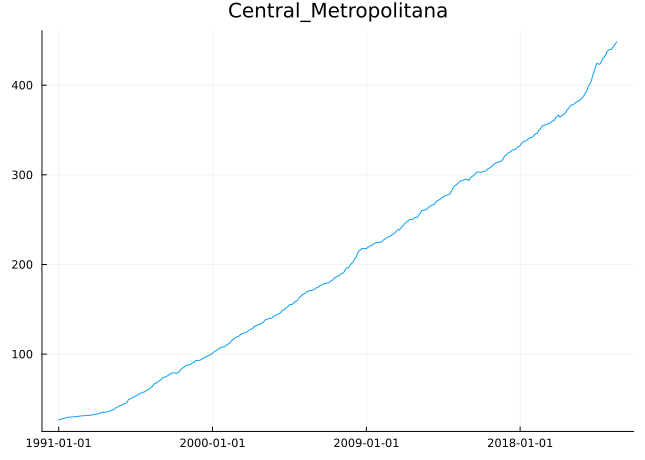

In [8]:
tipo = "line";
grupos2 = DataFrames.DataFrame(
	No = 1:Base.size(df_cpi_regiones, 2)-1,
	Nombre = DataFrames.names(df_cpi_regiones)[2:end]);
nombrar = Base.Array(grupos2.Nombre);
nombrar = string.(nombrar);
j = 1#size(nombrar)[1] # 1:8

#dynamic_plot(df, nombrar[i], tipo)
# static_plot(df_cpi_grupos, nombrar[j], tipo)
df, col_name, plot_type = df_cpi_regiones, nombrar[j], tipo
col_name = Symbol(col_name)
plot_type = Symbol(plot_type)
fig_002 = Plots.plot(
    df.Fechas, 
    df[:, col_name],
    legend = false,
    label = String(col_name),
    title = String(col_name),)
#=Plots.savefig(
	fig_002,
	wd * "/Figuras/fig_002.png")
FileIO.load(wd * "/Figuras/fig_002.png")=#

También puede aplicarse una regresión lineal para estimar los pesos por región:


In [9]:
data = copy(df_cpi_regiones[:,2:end])
reg = GLM.lm(GLM.@formula(IPC ~  0 + Central_Metropolitana + Resto_Central + Norte_Metropolitana + Resto_Norte + Sur + Oriental + Occidental),data)
w = coef(reg)
data[:,:IPC_estim] = data[:,end]
data[!,:IPC_estim] = 
	data.Central_Metropolitana .* w[1] + data.Resto_Central .* w[2] + data.Norte_Metropolitana .* w[3] + 
	data.Resto_Norte .* w[4] + data.Sur .* w[5] + data.Oriental .* w[6] +
	data.Occidental .* w[7]
data = hcat(df_cpi_regiones[:,1],data)
DataFrames.rename!(
	data, 
	Base.names(data)[1] .=> 
	"Fechas");
formato_tabla(data[end-20:end,:])

 ------------ ----------------------- --------------- --------------------- ------------- ---------- ---------- ------------ ---------- -----------
      Fechas   Central_Metropolitana   Resto_Central   Norte_Metropolitana   Resto_Norte        Sur   Oriental   Occidental        IPC   IPC_estim 
        Date                 Float64         Float64               Float64       Float64    Float64    Float64      Float64    Float64     Float64 
 ------------ ----------------------- --------------- --------------------- ------------- ---------- ---------- ------------ ---------- -----------
  2022-01-01                399.0000        359.6000              368.0000      343.0000   370.5000   366.4000     358.4000   373.0000    373.0451
  2022-02-01                401.5000        361.3000              368.6000      342.6000   373.1000   366.2000     358.9000   374.3000    374.2621
  2022-03-01                404.6000        368.4000              371.7000      346.6000   376.0000   370.6000    

# Pronóstico

## Seasonal ARIMA

### Model


In [10]:
log_ipc = log.(data.IPC)
model = StateSpaceModels.SARIMA(
    log_ipc; 
    order = (0, 1, 1), seasonal_order = (0, 1, 1, 12))
StateSpaceModels.fit!(model)
StateSpaceModels.print_results(model)

                             Results                           
Model:                        SARIMA(0, 1, 1)x(0, 1, 1, 12) with zero mean    
Number of observations:       393
Number of unknown parameters: 3

┌ Warning: The optimization process converged but the Hessian matrix is not positive definite. This means that StateSpaceModels.jl cannot estimate the distribution of the hyperparameters If you are interested in estimates of the distribution of ther hyperparameters we advise you tochange the optimization algorithm by using the kwarg fit(...; optimizer = Optimizer(StateSpaceModels.Optim.THE_METHOD_OF_YOUR_CHOICE()))The list of possible algorithms can be found on this link https://julianlsolvers.github.io/Optim.jl/stable/# otherwise you can simply skip this proccess by using fit(...; save_hyperparameter_distribution=false) 
└ @ StateSpaceModels C:\Users\ec109004\.julia\packages\StateSpaceModels\DmxMT\src\fit.jl:57



Log-likelihood:               1455.4642
AIC:                          -2904.9285
AICc:                         -2904.8668
BIC:                          -2893.0070
---------------------------------------------------------------
Parameter      Estimate      Std.Error      z stat      p-value
ma_L1            0.5002             -           -            - 
s_ma_L12        -0.7514             -           -            - 
sigma2_η         0.0000             -           -            - 


### Forecast


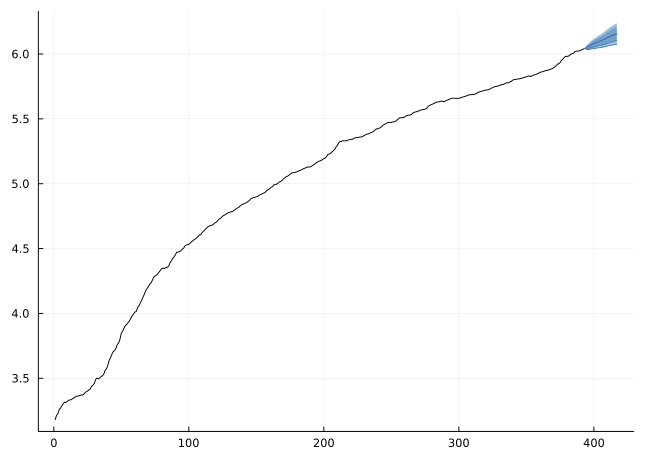

In [11]:
forec = StateSpaceModels.forecast(model, 24)
Plots.plot(model, forec; legend = :topleft, label = "")

## Auto ARIMA

### Model


In [12]:
log_ipc = log.(data.IPC)
seas = 12
steps_ahead = 12
model_auto_arima,forec_auto_arima,df_auto_arima = auto_arima(
	log_ipc, 
	seas, 
	steps_ahead);

### Forecast


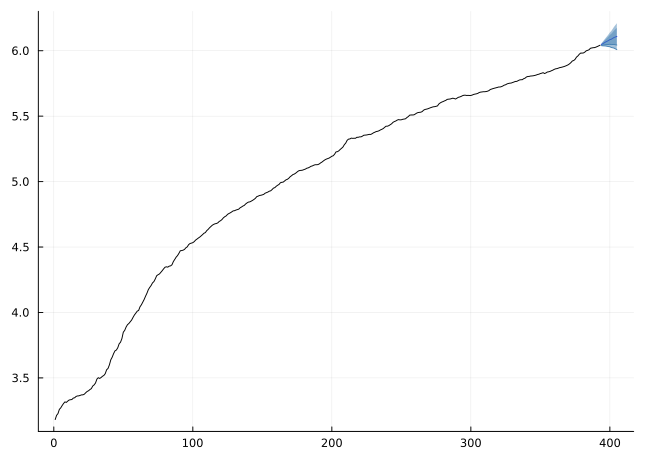

In [13]:
Plots.plot(
	model_auto_arima, 
	forec_auto_arima; 
	legend = :topleft, label = "")

In [14]:
ipc_for = data[:,[:Fechas,:IPC]]
fechas_last = data.Fechas[end]
#=fechas_for = Base.collect(
	Dates.Date(1991,1,1):Dates.Month(1):Dates.Date(1991,1,1)+Dates.Month(size(df_cpi_grupos)[1]-1))=#

2023-09-01